# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario2-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 289890 X 12514 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in [5,10,15,20]: #range(kmin, kmax + 1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../../../../data-pre-processing/2csv/cenario2_8M2020_tweets_es.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 289890 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("spanish.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 313 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:


docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12623 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario2_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.3034
K=10: Coherence=0.2833
K=15: Coherence=0.2646
K=20: Coherence=0.2730


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

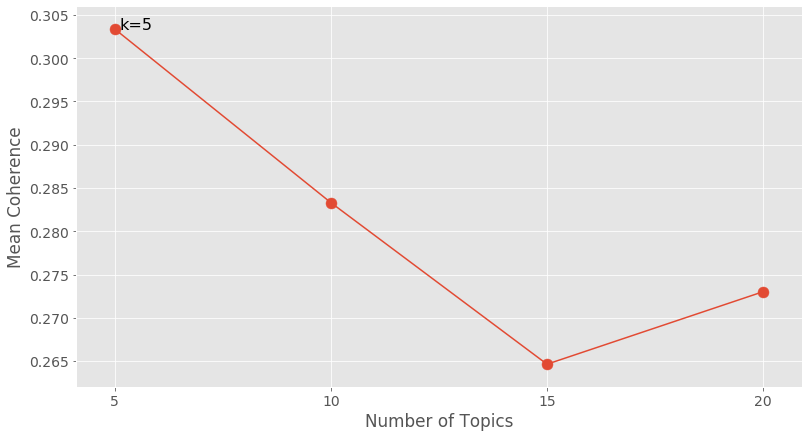

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [17]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2677
K=10: Coherence=0.2436
K=15: Coherence=0.2521
K=20: Coherence=0.2680


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


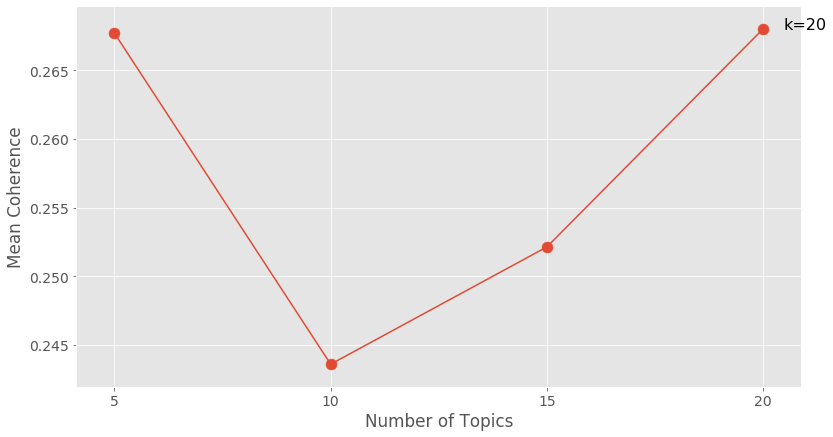

In [18]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15

In [19]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2386
K=10: Coherence=0.2466
K=15: Coherence=0.2468
K=20: Coherence=0.2613


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


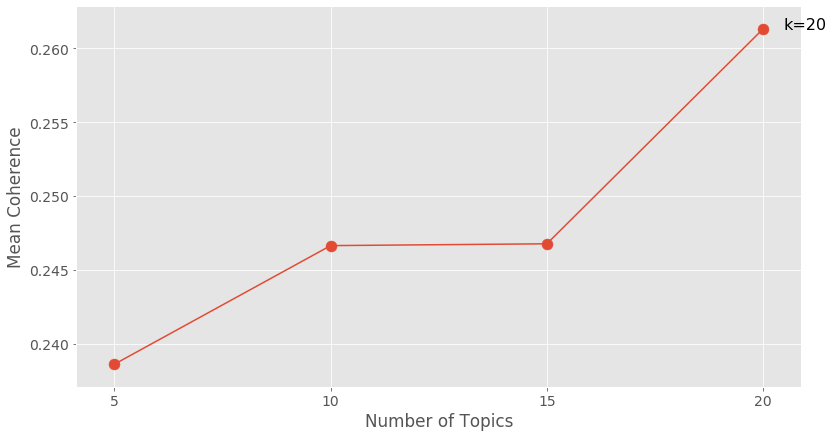

In [20]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [21]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 20))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.2303
K=10: Coherence=0.2401
K=15: Coherence=0.2427
K=20: Coherence=0.2595


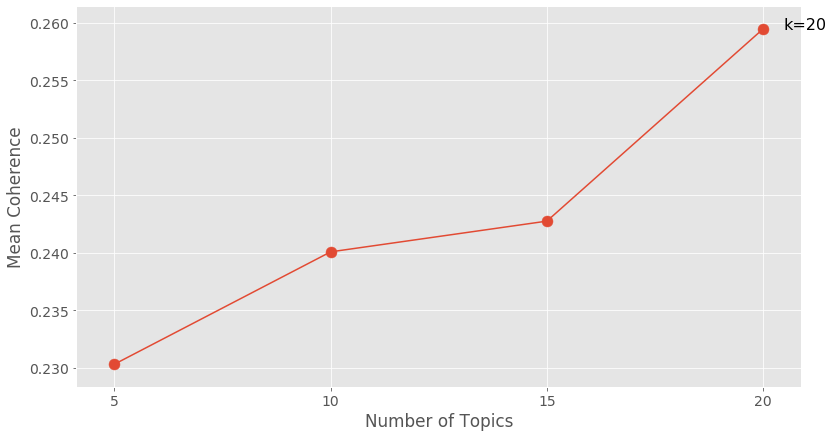

In [22]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

# 5

In [23]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, mujer, feliz, internacional, ser
Topic 02: mujeres, igualdad, derechos, hombres, mundo
Topic 03: todas, gracias, feliz, felicidades, mundo
Topic 04: hoy, siempre, lucha, dias, manana
Topic 05: marcha, ser, asi, feminista, mujer


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, mujer, feliz, internacional, ser, marzo, trabajadora, cada, lucha, mundo
Topic 02: mujeres, igualdad, derechos, hombres, mundo, violencia, lucha, genero, vida, sociedad
Topic 03: todas, gracias, feliz, felicidades, mundo, juntas, especial, amigas, companeras, aquellas
Topic 04: hoy, siempre, lucha, dias, manana, nunca, dia, igualdad, derechos, ano
Topic 05: marcha, ser, asi, feminista, mujer, ver, quiero, manana, solo, miedo


In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, mujer, feliz, internacional, ser, marzo, trabajadora, cada, lucha, mundo, conmemora, igualdad, especial, vida, hombre
Topic 02: mujeres, igualdad, derechos, hombres, mundo, violencia, lucha, genero, vida, sociedad, respeto, miles, solo, pais, historia
Topic 03: todas, gracias, feliz, felicidades, mundo, juntas, especial, amigas, companeras, aquellas, muchas, ustedes, abrazo, mejor, voz
Topic 04: hoy, siempre, lucha, dias, manana, nunca, dia, igualdad, derechos, ano, queremos, solo, voz, historia, calles
Topic 05: marcha, ser, asi, feminista, mujer, ver, quiero, manana, solo, miedo, primera, chile, bien, mexico, personas


In [27]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, mujer, feliz, internacional, ser, marzo, trabajadora, cada, lucha, mundo, conmemora, igualdad, especial, vida, hombre, dias, celebrar, conmemoracion, celebra, dejen
Topic 02: mujeres, igualdad, derechos, hombres, mundo, violencia, lucha, genero, vida, sociedad, respeto, miles, solo, pais, historia, mexico, feminismo, calles, trabajo, ninas
Topic 03: todas, gracias, feliz, felicidades, mundo, juntas, especial, amigas, companeras, aquellas, muchas, ustedes, abrazo, mejor, voz, quiero, vida, hermanas, queremos, luchan
Topic 04: hoy, siempre, lucha, dias, manana, nunca, dia, igualdad, derechos, ano, queremos, solo, voz, historia, calles, juntas, miedo, quiero, calle, ayer
Topic 05: marcha, ser, asi, feminista, mujer, ver, quiero, manana, solo, miedo, primera, chile, bien, mexico, personas, violencia, mil, tan, ahora, gobierno


# 10

In [28]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, marzo, celebrar
Topic 02: mujeres, hombres, mundo, violencia, vida
Topic 03: todas, felicidades, mundo, juntas, especial
Topic 04: hoy, siempre, dias, manana, nunca
Topic 05: mujer, internacional, marzo, trabajadora, hombre
Topic 06: marcha, asi, feminista, manana, ver
Topic 07: ser, quiero, miedo, libres, queremos
Topic 08: gracias, muchas, disponible, siempre, ultimo
Topic 09: lucha, igualdad, derechos, genero, feminismo
Topic 10: feliz, dias, dia, mundo, buenos


In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, marzo, celebrar, buen, especial, mejor, algun, luchan
Topic 02: mujeres, hombres, mundo, violencia, vida, miles, mexico, historia, pais, derechos
Topic 03: todas, felicidades, mundo, juntas, especial, aquellas, amigas, companeras, abrazo, voz
Topic 04: hoy, siempre, dias, manana, nunca, historia, voz, ano, solo, calles
Topic 05: mujer, internacional, marzo, trabajadora, hombre, via, vida, conmemora, mundo, celebra
Topic 06: marcha, asi, feminista, manana, ver, chile, primera, mil, mexico, personas
Topic 07: ser, quiero, miedo, libres, queremos, solo, vivas, puede, asi, vida
Topic 08: gracias, muchas, disponible, siempre, ultimo, diario, vida, mejor, tan, ustedes
Topic 09: lucha, igualdad, derechos, genero, feminismo, violencia, sociedad, respeto, feminista, oportunidades
Topic 10: feliz, dias, dia, mundo, buenos, dejen, domingo, falte, ninguna, siempre


In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, marzo, celebrar, buen, especial, mejor, algun, luchan, celebracion, conmemorar, conmemoracion, ano, trabajadora
Topic 02: mujeres, hombres, mundo, violencia, vida, miles, mexico, historia, pais, derechos, solo, chile, calles, ninas, valientes
Topic 03: todas, felicidades, mundo, juntas, especial, aquellas, amigas, companeras, abrazo, voz, luchan, queremos, hermanas, ustedes, cada
Topic 04: hoy, siempre, dias, manana, nunca, historia, voz, ano, solo, calles, ayer, marchamos, celebramos, juntas, buenos
Topic 05: mujer, internacional, marzo, trabajadora, hombre, via, vida, conmemora, mundo, celebra, valiente, madre, felicidades, sociedad, luchadora
Topic 06: marcha, asi, feminista, manana, ver, chile, primera, mil, mexico, personas, fotos, violencia, via, santiago, gobierno
Topic 07: ser, quiero, miedo, libres, queremos, solo, vivas, puede, asi, vida, debe, nunca, libre, feminista, tan
Topic 08: gracias, muchas, disponible, siempre, ultimo, diario, vida

In [32]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, marzo, celebrar, buen, especial, mejor, algun, luchan, celebracion, conmemorar, conmemoracion, ano, trabajadora, recordar, gran, conmemora, felicitar, historico
Topic 02: mujeres, hombres, mundo, violencia, vida, miles, mexico, historia, pais, derechos, solo, chile, calles, ninas, valientes, trabajadoras, trabajo, muchas, millones, hacen
Topic 03: todas, felicidades, mundo, juntas, especial, aquellas, amigas, companeras, abrazo, voz, luchan, queremos, hermanas, ustedes, cada, mejor, luchando, vamos, respeto, unidas
Topic 04: hoy, siempre, dias, manana, nunca, historia, voz, ano, solo, calles, ayer, marchamos, celebramos, juntas, buenos, calle, marchar, conmemoramos, vamos, conmemora
Topic 05: mujer, internacional, marzo, trabajadora, hombre, via, vida, conmemora, mundo, celebra, valiente, madre, felicidades, sociedad, luchadora, historia, gran, dios, conmemoracion, amor
Topic 06: marcha, asi, feminista, manana, ver, chile, primera, mil, mexico, perso

# 15

In [33]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, marzo, celebrar
Topic 02: mujeres, hombres, violencia, miles, vida
Topic 03: todas, felicidades, especial, juntas, aquellas
Topic 04: hoy, dias, manana, nunca, historia
Topic 05: mujer, internacional, marzo, trabajadora, hombre
Topic 06: marcha, feminista, manana, primera, chile
Topic 07: ser, solo, puede, debe, feminista
Topic 08: gracias, muchas, disponible, ultimo, diario
Topic 09: igualdad, derechos, genero, violencia, feminismo
Topic 10: feliz, dias, dia, buenos, dejen
Topic 11: asi, mexico, bien, manifestacion, aun
Topic 12: lucha, feminista, derechos, sigue, conmemora
Topic 13: siempre, manana, nunca, juntas, vida
Topic 14: mundo, mejor, cada, hacer, vida
Topic 15: queremos, miedo, libres, quiero, vivas


In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, marzo, celebrar, buen, especial, algun, celebracion, conmemorar
Topic 02: mujeres, hombres, violencia, miles, vida, historia, mexico, pais, solo, derechos
Topic 03: todas, felicidades, especial, juntas, aquellas, amigas, companeras, abrazo, voz, luchan
Topic 04: hoy, dias, manana, nunca, historia, voz, ano, solo, calles, ayer
Topic 05: mujer, internacional, marzo, trabajadora, hombre, via, conmemora, vida, celebra, valiente
Topic 06: marcha, feminista, manana, primera, chile, ver, mil, personas, fotos, santiago
Topic 07: ser, solo, puede, debe, feminista, vida, tan, hombre, dias, deberia
Topic 08: gracias, muchas, disponible, ultimo, diario, vida, tan, ustedes, amor, amo
Topic 09: igualdad, derechos, genero, violencia, feminismo, respeto, hombres, sociedad, real, oportunidades
Topic 10: feliz, dias, dia, buenos, dejen, domingo, falte, ninguna, desea, deseamos
Topic 11: asi, mexico, bien, manifestacion, aun, cosas, solo, ojala, gente, ver
Topic 12: lu

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, marzo, celebrar, buen, especial, algun, celebracion, conmemorar, luchan, conmemoracion, ano, trabajadora, recordar
Topic 02: mujeres, hombres, violencia, miles, vida, historia, mexico, pais, solo, derechos, calles, valientes, trabajadoras, chile, muchas
Topic 03: todas, felicidades, especial, juntas, aquellas, amigas, companeras, abrazo, voz, luchan, hermanas, ustedes, pueden, saludo, respeto
Topic 04: hoy, dias, manana, nunca, historia, voz, ano, solo, calles, ayer, marchamos, celebramos, buenos, conmemoramos, marchar
Topic 05: mujer, internacional, marzo, trabajadora, hombre, via, conmemora, vida, celebra, valiente, madre, felicidades, luchadora, sociedad, historia
Topic 06: marcha, feminista, manana, primera, chile, ver, mil, personas, fotos, santiago, mexico, violencia, via, multitudinaria, plaza
Topic 07: ser, solo, puede, debe, feminista, vida, tan, hombre, dias, deberia, parte, orgullosa, dejen, quiero, libre
Topic 08: gracias, muchas, disponi

In [37]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, marzo, celebrar, buen, especial, algun, celebracion, conmemorar, luchan, conmemoracion, ano, trabajadora, recordar, gran, felicitar, historico, ojala, conmemora
Topic 02: mujeres, hombres, violencia, miles, vida, historia, mexico, pais, solo, derechos, calles, valientes, trabajadoras, chile, muchas, ninas, trabajo, millones, grandes, marchan
Topic 03: todas, felicidades, especial, juntas, aquellas, amigas, companeras, abrazo, voz, luchan, hermanas, ustedes, pueden, saludo, respeto, cada, luchadoras, admiracion, luchando, reconocimiento
Topic 04: hoy, dias, manana, nunca, historia, voz, ano, solo, calles, ayer, marchamos, celebramos, buenos, conmemoramos, marchar, calle, conmemora, celebra, vamos, hace
Topic 05: mujer, internacional, marzo, trabajadora, hombre, via, conmemora, vida, celebra, valiente, madre, felicidades, luchadora, sociedad, historia, gran, conmemoracion, participacion, dios, amor
Topic 06: marcha, feminista, manana, primera, chile, v

# 20

In [38]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

Display the topic descriptors for this model:

In [39]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, especial, buen
Topic 02: mujeres, hombres, miles, derechos, vida
Topic 03: todas, felicidades, especial, juntas, aquellas
Topic 04: hoy, manana, nunca, voz, historia
Topic 05: mujer, internacional, trabajadora, hombre, vida
Topic 06: marcha, manana, primera, mil, chile
Topic 07: ser, puede, debe, vida, deberia
Topic 08: gracias, muchas, disponible, ultimo, diario
Topic 09: igualdad, derechos, respeto, hombres, oportunidades
Topic 10: feliz, dia, dejen, ninguna, falte
Topic 11: asi, aun, mexico, ojala, vivio
Topic 12: lucha, derechos, sigue, feminista, conmemora
Topic 13: queremos, libres, vivas, miedo, juntas
Topic 14: mundo, mejor, cada, justo, vida
Topic 15: siempre, manana, juntas, nunca, vida
Topic 16: dias, buenos, ano, solo, vida
Topic 17: marzo, internacional, via, domingo, conmemora
Topic 18: violencia, genero, mexico, machista, pais
Topic 19: quiero, miedo, libre, manana, casa
Topic 20: feminismo, feminista, solo, bien, manifestacion


In [40]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, especial, buen, celebrar, algun, luchan, conmemorar, celebracion
Topic 02: mujeres, hombres, miles, derechos, vida, historia, valientes, trabajadoras, pais, ninas
Topic 03: todas, felicidades, especial, juntas, aquellas, amigas, abrazo, companeras, voz, luchan
Topic 04: hoy, manana, nunca, voz, historia, marchamos, celebramos, conmemoramos, calles, ayer
Topic 05: mujer, internacional, trabajadora, hombre, vida, valiente, madre, luchadora, felicidades, sociedad
Topic 06: marcha, manana, primera, mil, chile, multitudinaria, fotos, santiago, pacifica, cdmx
Topic 07: ser, puede, debe, vida, deberia, dejen, orgullosa, parte, ninguna, libre
Topic 08: gracias, muchas, disponible, ultimo, diario, vida, tan, amor, ustedes, amo
Topic 09: igualdad, derechos, respeto, hombres, oportunidades, real, genero, sociedad, libertad, luchando
Topic 10: feliz, dia, dejen, ninguna, falte, domingo, desea, deseamos, luchadoras, vida
Topic 11: asi, aun, mexico, ojala, vivio, 

In [41]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, especial, buen, celebrar, algun, luchan, conmemorar, celebracion, trabajadora, conmemoracion, recordar, gran, felicitar
Topic 02: mujeres, hombres, miles, derechos, vida, historia, valientes, trabajadoras, pais, ninas, muchas, grandes, trabajo, chile, luchadoras
Topic 03: todas, felicidades, especial, juntas, aquellas, amigas, abrazo, companeras, voz, luchan, hermanas, ustedes, cada, pueden, saludo
Topic 04: hoy, manana, nunca, voz, historia, marchamos, celebramos, conmemoramos, calles, ayer, marchar, conmemora, calle, celebra, salimos
Topic 05: mujer, internacional, trabajadora, hombre, vida, valiente, madre, luchadora, felicidades, sociedad, conmemora, celebra, gran, dios, amor
Topic 06: marcha, manana, primera, mil, chile, multitudinaria, fotos, santiago, pacifica, cdmx, plaza, carabineros, personas, asistentes, zocalo
Topic 07: ser, puede, debe, vida, deberia, dejen, orgullosa, parte, ninguna, libre, humano, tan, hecho, falte, hombre
Topic 08: gr

In [42]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, especial, buen, celebrar, algun, luchan, conmemorar, celebracion, trabajadora, conmemoracion, recordar, gran, felicitar, historico, importante, llegue, ojala, festejar
Topic 02: mujeres, hombres, miles, derechos, vida, historia, valientes, trabajadoras, pais, ninas, muchas, grandes, trabajo, chile, luchadoras, millones, especial, calles, fuertes, marchan
Topic 03: todas, felicidades, especial, juntas, aquellas, amigas, abrazo, companeras, voz, luchan, hermanas, ustedes, cada, pueden, saludo, luchadoras, admiracion, respeto, reconocimiento, luchando
Topic 04: hoy, manana, nunca, voz, historia, marchamos, celebramos, conmemoramos, calles, ayer, marchar, conmemora, calle, celebra, salimos, marcho, luchar, recordar, marche, vamos
Topic 05: mujer, internacional, trabajadora, hombre, vida, valiente, madre, luchadora, felicidades, sociedad, conmemora, celebra, gran, dios, amor, fuerte, participacion, primera, amiga, venezolana
Topic 06: marcha, manana, prim